# Project 2 - Prediciting Release Year of Songs on Spotify

### By: Sam Busane & Andrew Cline

## Introduction

From Kaggle we have a data set that holds the catalog of songs from the music streamin app Spotify. The list of songs has some that date back to the 1940s. The data set also holds information about each song such as danceability, tempo, acousticness, and popularity as well as others. Using these traits we want to build a model that can accurately predict the decade in which a song was released.

Link to Dataset: https://www.kaggle.com/yamaerenay/spotify-dataset-19212020-160k-tracks

In [111]:
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import export_graphviz
from scipy.stats import zscore
from scipy.cluster.hierarchy import dendrogram, linkage

In [112]:
df = pd.read_csv('data.csv')

## Initial Exploration

This dataset is quite large since it encompasses the whole of Spotify's song library. Since the goal is to predict the year a song came out it is important to look for variables that would intuitively be tied to changes over time.

In [113]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170653 entries, 0 to 170652
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   valence           170653 non-null  float64
 1   year              170653 non-null  int64  
 2   acousticness      170653 non-null  float64
 3   artists           170653 non-null  object 
 4   danceability      170653 non-null  float64
 5   duration_ms       170653 non-null  int64  
 6   energy            170653 non-null  float64
 7   explicit          170653 non-null  int64  
 8   id                170653 non-null  object 
 9   instrumentalness  170653 non-null  float64
 10  key               170653 non-null  int64  
 11  liveness          170653 non-null  float64
 12  loudness          170653 non-null  float64
 13  mode              170653 non-null  int64  
 14  name              170653 non-null  object 
 15  popularity        170653 non-null  int64  
 16  release_date      17

Looking at the dataframe info it shows that almost all of the data in this dataset is numeric, save for explicit, release date, name, artists, and id. Some of the columns are not relevant to the predictions that are going to be made, so they will be removed later.

In [114]:
df.isna().sum()

valence             0
year                0
acousticness        0
artists             0
danceability        0
duration_ms         0
energy              0
explicit            0
id                  0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
name                0
popularity          0
release_date        0
speechiness         0
tempo               0
dtype: int64

Since this dataset was obtained from Kaggle the expectation is that it would be very clean and this dataset is no exception. There are no NA values, so there is no cleaning needed.

## Preprocessing

The dataset contains some values that would not help develop a model. These values would be artists, id, name, and release_date since they are purely identifying features of a song and would be unhelpful for developing a model. So they should be removed from the dataset. 

In [115]:
df.drop(['id', 'release_date', 'name', 'artists'], axis=1, inplace=True)

Recorded music is a relatively new advent and it was not widely popular until a few decades after its release. So there may be skewed data the farther back in time that the data goes. To make visualization easier the songs will be binned together by decade and added to a new column.

In [116]:
df['decade'] = pd.cut(df['year'], bins=[1920,1929,1939,1949,1959,1969,1979,1989,1999,2009,2029], labels=['20s', '30s','40s',
                                                                                                        '50s','60s','70s',
                                                                                                        '80s', '90s', '2000s',
                                                                                                        '2010s'])

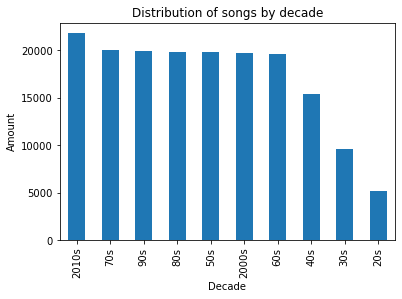

In [117]:
df['decade'].value_counts().plot.bar()
plt.title('Distribution of songs by decade')
plt.xlabel('Decade')
plt.ylabel('Amount');

So there is clearly an under-representation of the data before 1950. So it would be good for developing the model if those data points were dropped so that they do not skew the model.

In [118]:
df = df[df['year'] >= 1950]
df['decade'] = pd.cut(df['year'], bins=[1949,1959,1969,1979,1989,1999,2009,2029], labels=['50s','60s','70s',
                                                                                          '80s', '90s', '2000s',
                                                                                          '2010s'])

## Visualization 

When developing the model strongly correlated values should be avoided because the correlation may be overrepresented in the model and skew the predictions.

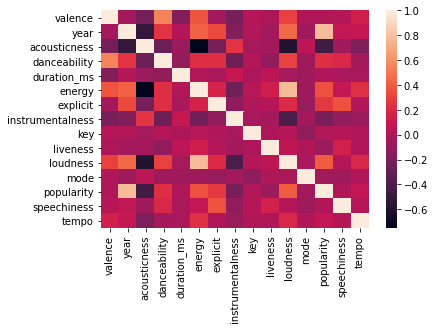

In [119]:
corr = df.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)

Acousticness is very strongly correlated to a lot of values. It would be imperative to include it in the final model because it represents so much in terms of correlation.

Since most people group music by decade it would useful to see changes over the decades in the various numeric values of the dataset.

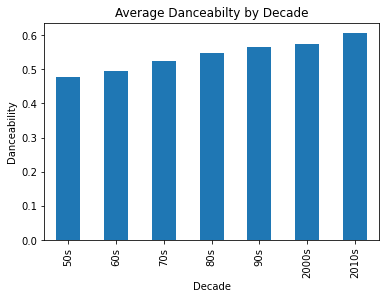

In [120]:
df.groupby('decade')['danceability'].mean().plot.bar()
plt.title('Average Danceabilty by Decade')
plt.xlabel('Decade')
plt.ylabel('Danceability');

The graph shows that there is a small trend of danceability increasing with time. Due to this value having a clear change over time it would be good to include it in the model as a predictor.

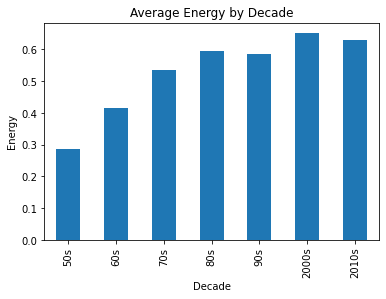

In [121]:
df.groupby('decade')['energy'].mean().plot.bar()
plt.title('Average Energy by Decade')
plt.xlabel('Decade')
plt.ylabel('Energy');

An odd trend is shown in this graph. Over time there is an increase in energy until the 80s then the value again stagnates like acousticness. Energy represents how fast, loud, and noisy the song is, this trend could be due to the proliferation and development of rock over time. As rock progressed it generally got more and more fast and noisy. Another value to consider for the model.

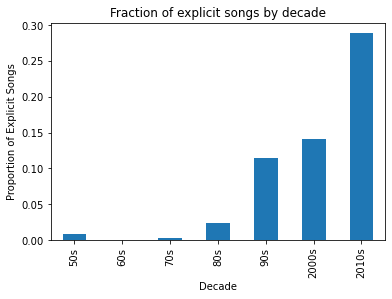

In [122]:
tbl = df.groupby('decade')['explicit'].apply(lambda x: (x == 1).mean())
tbl.plot.bar()
plt.title('Fraction of explicit songs by decade')
plt.xlabel('Decade')
plt.ylabel('Proportion of Explicit Songs');

The graph showcases another intuitive trend. The trend of music getting more explicit also coincides with the rise of rap, which tends to be more explicit than another genre. This could a helpful predictor since it again changes over time.

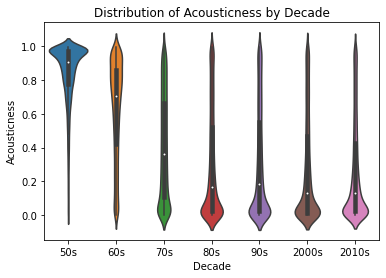

In [123]:
sns.violinplot(x='decade', y='acousticness', data=df)
plt.title('Distribution of Acousticness by Decade')
plt.xlabel('Decade')
plt.ylabel('Acousticness');

This graph makes sense intuitively since electronically produced music is a relatively newer type of music, but the graph does show a kind of stagnation of acousticness from the 80s to the 2010s. But since this value is tightly related to other values it should be included in the model.

## Building the Model

In [124]:
predictors = ['valence', 'acousticness', 'danceability','explicit', 'instrumentalness', 
              'speechiness', 'popularity', 'liveness', 'mode', 'tempo']
X = df[predictors].values
y = df['year'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

This dataset came with a lot of features for each song so there are plenty of predictors to choose from when it comes to building the model. But using all the features of the dataset is not very useful especially the ones that did not seem to change with time such as duration_ms.

## The Models 

Since the predictions that are going to be made are going to be numeric, the algorithms that will be used are forms of regression. The algorithms that were chosen were Decision Tree Regression, Linear Regression, and KNN Regression. They will be compared using RMSE and after the initial development forward feature selection will be used to see if the model improves.

In [125]:
def forward_feature_selection(X_train,y_train,model):
        remaining = list(range(X_train.shape[1]))
        selected = []
        n = 10
        while len(selected) < n:
            rmse_min = 1e7,
            for i in remaining:
                X_i = X_train[:,selected+[i]]
                scores = cross_val_score(model, X_i, y_train, scoring='neg_mean_squared_error', cv=10)
                rmse = np.sqrt(-scores.mean())
                if rmse < rmse_min:
                    rmse_min = rmse
                    i_min = i
            remaining.remove(i_min)
            selected.append(i_min)
            print('num features: {}; rmse: {:.2f}'.format(len(selected), rmse_min))
        return selected

Generalized forward feature selection method, the model and training data can be passed in and it will return the indexes of the best features in the predictor list.

In [126]:
baseline = df['year'].mean()
baselineRMSE = np.sqrt(((df['year'] - baseline)**2).mean())
print('Baseline RMSE: {:.2f}'.format(baselineRMSE))

Baseline RMSE: 20.47


A baseline RMSE that is just the RMSE of the mean values will help compare the developed models and see if the model is improving.

### Decision Tree Regressor

In [127]:
treereg = DecisionTreeRegressor(max_depth=3)
treereg.fit(X_train, y_train)
y_predict = treereg.predict(X_test)

In [128]:
scores = -cross_val_score(treereg, X, y, scoring='neg_mean_squared_error', cv=10)

scores.mean()
rmse = np.sqrt(scores.mean()).mean()
print(rmse)

13.566303551328325


Decision Tree Regression with all selected features produces an RMSE of 13.57, which is better than the baseline RMSE. This model could be improved through forward feature selection.

In [129]:
best_array = forward_feature_selection(X_train, y_train, treereg)
feature_names = []
for i in best_array:
    feature_names.append(predictors[i])
print(feature_names)

num features: 1; rmse: 12.66
num features: 2; rmse: 12.34
num features: 3; rmse: 12.27
num features: 4; rmse: 12.27
num features: 5; rmse: 12.27
num features: 6; rmse: 12.27
num features: 7; rmse: 12.27
num features: 8; rmse: 12.27
num features: 9; rmse: 12.27
num features: 10; rmse: 12.27
['popularity', 'acousticness', 'explicit', 'valence', 'danceability', 'instrumentalness', 'speechiness', 'liveness', 'mode', 'tempo']


The RMSE with forward feature shows that 3 features are really contributing to the predictions which are popularity, acousticness, and explicit and adding more features does not increase the RMSE past 12.27.

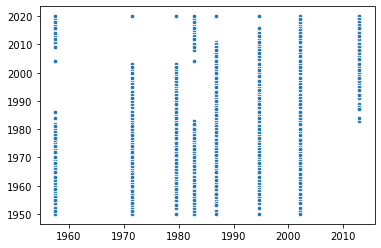

In [130]:
sns.scatterplot(x=y_predict, y=y_test, s=20)

This graph plots predicted versus actual values and shows that the model has issues with predicting years before 1960 and between 1980 and 1990.

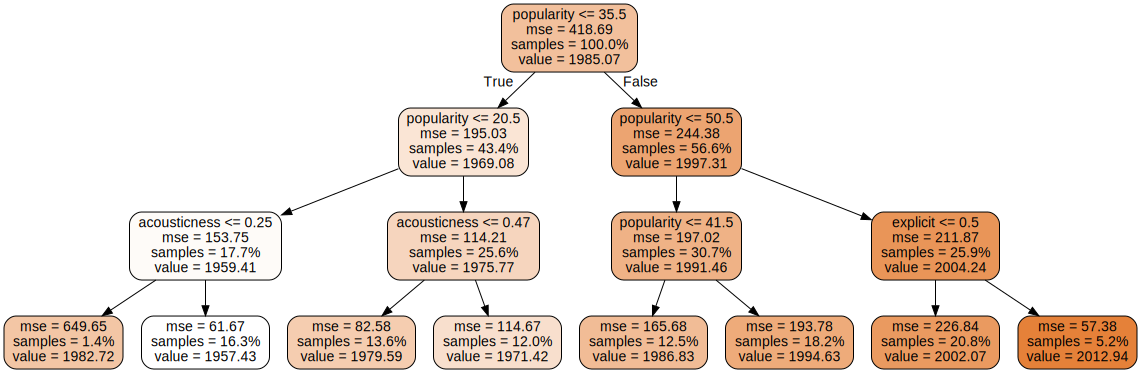

In [131]:
dot_data= export_graphviz(treereg, precision=2,feature_names=predictors,  proportion=True,filled=True, rounded=True) 

graph = graphviz.Source(dot_data)
graph

The same issue is shown in the tree as well. The MSE values around those problem areas have a high MSE value compared to the other branches.

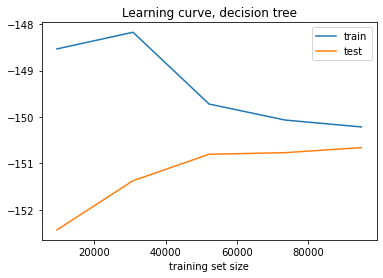

In [132]:
train_sizes, train_scores, test_scores = learning_curve(treereg, X_train, y_train, cv=10, 
                                                         scoring='neg_mean_squared_error')
train_scores_mean = np.mean(train_scores, axis = 1)
test_scores_mean = np.mean(test_scores, axis = 1)
plt.plot(train_sizes, train_scores_mean, label='train')
plt.plot(train_sizes, test_scores_mean, label='test')
plt.xlabel('training set size')
plt.title('Learning curve, decision tree')
plt.legend();

From the learning curve, it shows that there is high variance, so if we were to develop this model further we should remove features to help mitigate that.

Now let us see if there is an improvement using a higher max_depths.

In [133]:
treereg5 = DecisionTreeRegressor(max_depth=5)
treereg5.fit(X_train, y_train)
y_predict = treereg5.predict(X_test)

In [134]:
y_predict = treereg5.predict(X_test)
scores = -cross_val_score(treereg5, X, y, scoring='neg_mean_squared_error', cv=10)

scores.mean()
rmse = np.sqrt(scores.mean()).mean()
print(rmse)

12.719677990838004


Already there is an improvement in RMSE and this is without forward feature selection. Now, let’s use forward feature selection and see if there is a larger improvement.

In [135]:
best_array = forward_feature_selection(X_train, y_train, treereg5)
feature_names = []
for i in best_array:
    feature_names.append(predictors[i])
print(feature_names)

num features: 1; rmse: 12.49
num features: 2; rmse: 11.68
num features: 3; rmse: 11.50
num features: 4; rmse: 11.48
num features: 5; rmse: 11.46
num features: 6; rmse: 11.46
num features: 7; rmse: 11.46
num features: 8; rmse: 11.46
num features: 9; rmse: 11.46
num features: 10; rmse: 11.46
['popularity', 'acousticness', 'explicit', 'valence', 'speechiness', 'instrumentalness', 'liveness', 'mode', 'tempo', 'danceability']


Increasing the max depth also decreased the RMSE of the model and also the RMSE continued to lower with 5 features so this model also allows for more predictors.

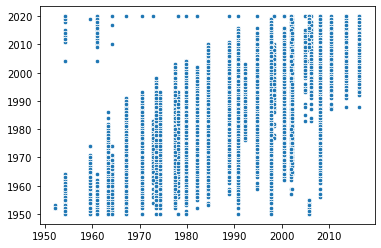

In [136]:
sns.scatterplot(x=y_predict, y=y_test, s=20)

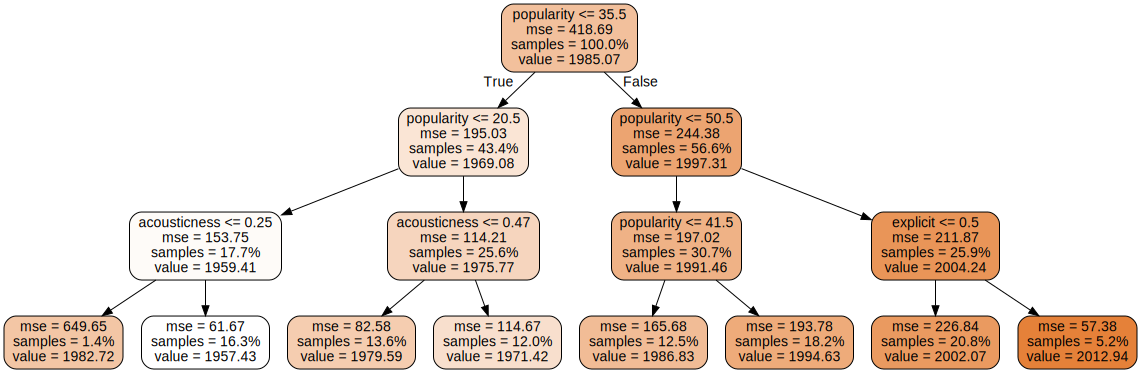

In [137]:
dot_data= export_graphviz(treereg, precision=2,feature_names=predictors,  proportion=True,filled=True, rounded=True) 

graph = graphviz.Source(dot_data)
graph

The same kind of errors are present in this model, it just to make them less. Perhaps the datapoints around those years are skewing the data in some way and it is more of an issue with the predictors themselves rather than the model needing to be fine-tuned.

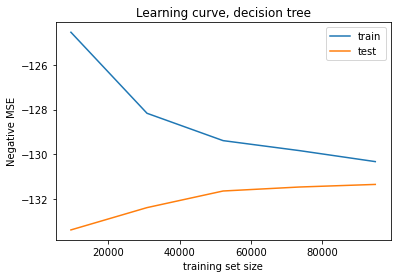

In [138]:
train_sizes, train_scores, test_scores = learning_curve(treereg5, X_train, y_train, cv=10, 
                                                         scoring='neg_mean_squared_error')
train_scores_mean = np.mean(train_scores, axis = 1)
test_scores_mean = np.mean(test_scores, axis = 1)
plt.plot(train_sizes, train_scores_mean, label='train')
plt.plot(train_sizes, test_scores_mean, label='test')
plt.ylabel('Negative MSE')
plt.xlabel('training set size')
plt.title('Learning curve, decision tree')
plt.legend();

Again the same kind of issues is present in this learning curve, just with lower absolute MSE values. The learning curve shows high variance and the need of reducing the number of predictors.

### Linear Regression

In [139]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_predict = linreg.predict(X_test)

In [140]:
best_array=forward_feature_selection(X_train,y_train, linreg)

num features: 1; rmse: 12.78
num features: 2; rmse: 12.24
num features: 3; rmse: 12.04
num features: 4; rmse: 11.89
num features: 5; rmse: 11.76
num features: 6; rmse: 11.74
num features: 7; rmse: 11.73
num features: 8; rmse: 11.73
num features: 9; rmse: 11.73
num features: 10; rmse: 11.73


In [141]:
feature_names=[]
for i in best_array:
    feature_names.append(predictors[i])
feature_names

['popularity',
 'acousticness',
 'explicit',
 'valence',
 'danceability',
 'tempo',
 'instrumentalness',
 'speechiness',
 'liveness',
 'mode']

<p>In the case of linear regression, the model's RMSE stops decreasing at 6 features and the best features are popularity, acousticness, explicit, valence, danceability, and tempo.</p>

In [142]:
scores = -cross_val_score(linreg, X, y, scoring='neg_mean_squared_error', cv=10)

scores.mean()
rmse = np.sqrt(scores.mean()).mean()
print(rmse)

12.551134896275828


<p>As we can see we get a lower RMSE than the decision tree when we use forward feature selection to find the best predictors for the model.</p>

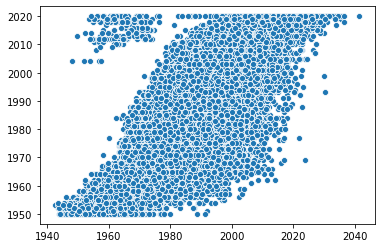

In [143]:
sns.scatterplot(x=y_predict, y=y_test)

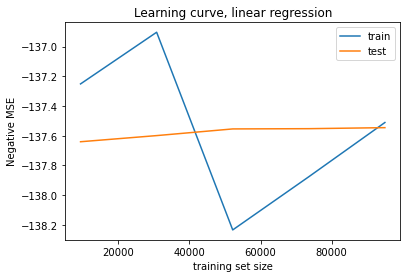

In [144]:
train_sizes, train_scores, test_scores = learning_curve(linreg, X_train, y_train, cv=10, 
                                                         scoring='neg_mean_squared_error')
train_scores_mean = np.mean(train_scores, axis = 1)
test_scores_mean = np.mean(test_scores, axis = 1)
plt.plot(train_sizes, train_scores_mean, label='train')
plt.plot(train_sizes, test_scores_mean, label='test')
plt.ylabel('Negative MSE')
plt.xlabel('training set size')
plt.title('Learning curve, linear regression')
plt.legend();

The learning curve for linear regression clearly shows that there is a high bias in this model.

### KNN Regressor

In [145]:
knn = KNeighborsRegressor(n_neighbors=3)
knn.fit(X_train, y_train)
y_predict = knn.predict(X_test)

In [146]:
scores = -cross_val_score(knn, X, y, scoring='neg_mean_squared_error', cv=10)

scores.mean()
rmse = np.sqrt(scores.mean()).mean()
print('RMSE: {:.2f}'.format(rmse))

RMSE: 13.87


By far the worst model out of the 3. Still out performs the baseline but even with cross-validation it performs the worst.

In [147]:
best_array=forward_feature_selection(X_train,y_train, knn)
feature_names=[]
for i in best_array:
    feature_names.append(predictors[i])
feature_names

num features: 1; rmse: 14.12
num features: 2; rmse: 13.27
num features: 3; rmse: 12.96
num features: 4; rmse: 12.77
num features: 5; rmse: 12.41
num features: 6; rmse: 12.34
num features: 7; rmse: 12.30
num features: 8; rmse: 12.27
num features: 9; rmse: 12.34
num features: 10; rmse: 12.93


['popularity',
 'acousticness',
 'explicit',
 'valence',
 'danceability',
 'speechiness',
 'instrumentalness',
 'mode',
 'liveness',
 'tempo']

With knn the model performs best with 8 features which are popularity, acousticness, explicit, valence, danceability, speechiness, instrumentalness, and mode. Again still the worst out of the 3 models.

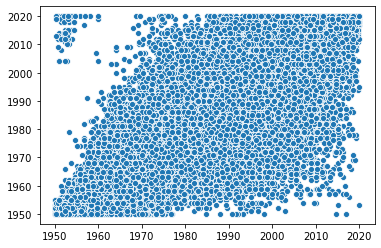

In [148]:
sns.scatterplot(x=y_predict, y=y_test)

This appears to have the same kind of errors the other models made, but with larger quantities

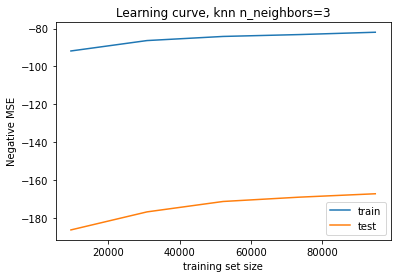

In [149]:
train_sizes, train_scores, test_scores = learning_curve(knn, X_train, y_train, cv=10, 
                                                         scoring='neg_mean_squared_error')
train_scores_mean = np.mean(train_scores, axis = 1)
test_scores_mean = np.mean(test_scores, axis = 1)
plt.plot(train_sizes, train_scores_mean, label='train')
plt.plot(train_sizes, test_scores_mean, label='test')
plt.ylabel('Negative MSE')
plt.xlabel('training set size')
plt.title('Learning curve, knn n_neighbors=3')
plt.legend();

A very clear case of high variance, reducing features would help this model.

<h4>Buidling the Model with the Best Parameters</h4>

In [150]:
param_grid = {'n_neighbors': np.arange(1, 10)}
knn_grid = GridSearchCV(KNeighborsRegressor(), param_grid, cv=5)

In [151]:
knn_grid.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': array([1, 2, 3, 4, 5, 6, 7, 8, 9])})

In [152]:
knn_grid.best_params_

{'n_neighbors': 9}

In [153]:
knn2=KNeighborsRegressor(n_neighbors=9)
knn2.fit(X_train,y_train)
y_predict = knn2.predict(X_test)

In [154]:
scores = -cross_val_score(knn2, X, y, scoring='neg_mean_squared_error', cv=10)

scores.mean()
rmse = np.sqrt(scores.mean()).mean()
print('RMSE: {:.2f}'.format(rmse))

RMSE: 13.18


<p>Using the grid search we come to the conclusion that the ideal number of neighbors is 9 for this model. It is not worth the amount of computing time to apply forward feature selection to this model, since it underperformed earlier and it clearly is not the best model for this application.</p>

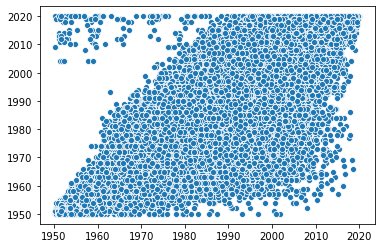

In [155]:
sns.scatterplot(x=y_predict, y=y_test)

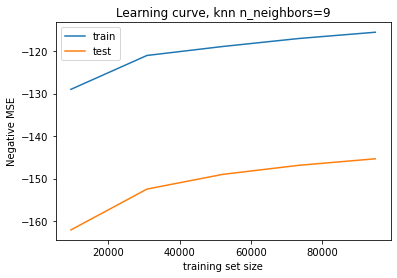

In [156]:
train_sizes, train_scores, test_scores = learning_curve(knn2, X_train, y_train, cv=10, 
                                                         scoring='neg_mean_squared_error')
train_scores_mean = np.mean(train_scores, axis = 1)
test_scores_mean = np.mean(test_scores, axis = 1)
plt.plot(train_sizes, train_scores_mean, label='train')
plt.plot(train_sizes, test_scores_mean, label='test')
plt.ylabel('Negative MSE')
plt.xlabel('training set size')
plt.title('Learning curve, knn n_neighbors=9')
plt.legend();

### Cluster Analysis

Cluster Analysis can show relationships that are not normally apparent in the dataset and help develop models if we were going to continue to refine this one. The only problem is that K-means cluster analysis does not give any meaningful interpretation when it comes to categorical variables so the categorical predictors should be removed for this algorithm. Also, the values will be scaled with zscore so that the algorithm has an easier time with clustering, this is mostly because tempo values are not scaled from 0 to 1.

In [157]:
predictors = ['valence', 'acousticness', 'danceability','instrumentalness', 
              'speechiness', 'popularity', 'mode', 'tempo']
df1 = df[predictors].apply(zscore)
X = df1[predictors].values

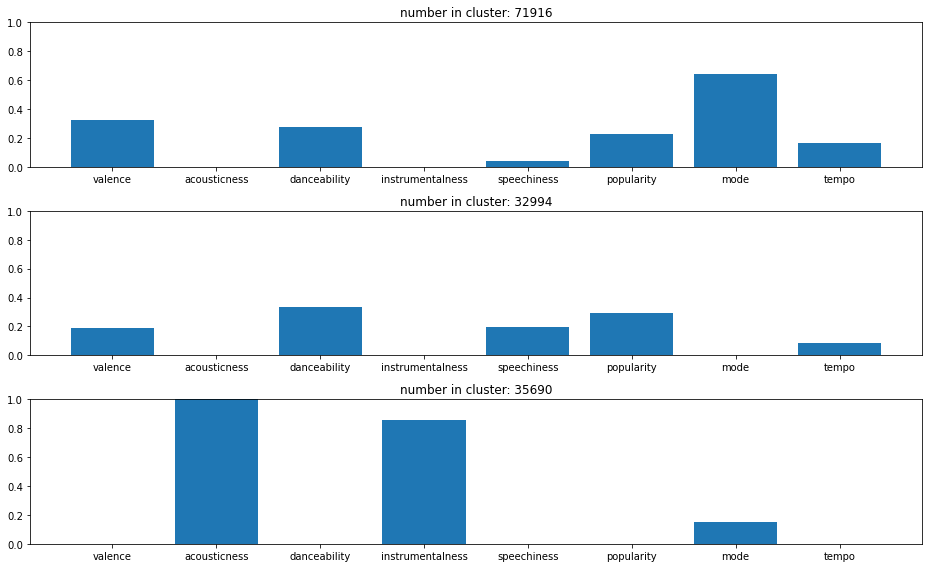

In [158]:
k = 3
kmeans = KMeans(n_clusters=k)
kmeans.fit(X)
centers = kmeans.cluster_centers_
counts = np.bincount(kmeans.labels_)
n = len(predictors)

fix, ax = plt.subplots(k, 1, figsize=(13,8))
for i, axi in enumerate(ax.flat):
    axi.bar(range(n), centers[i,:])
    axi.set_title('number in cluster: {}'.format(counts[i]))
    axi.set_ylim(0, 1)
    axi.set_xticks(range(n))
    axi.set_xticklabels(df1.columns[:n])
plt.tight_layout()


<p>Visualizing the clusters shows that each cluster has distinct features that represent it. The first cluster is linked to acousticness and instrumentalness, the second is valence, danceability, speechiness, popularity, and tempo, and finally, the third cluster is valence, danceability, popularity, and mode. This information is really helpful because if we were to continue to refine this model it would be beneficial to look into how to combine these features because clearly they are linked.</p>

### Conclusion

<p>After trying out three different machine learning, we can conclude that in terms of predicting the decade in which a song was released, linear regression yielded the closest predictions. After applying feature selection to the models, linear regression yielded the lowest Root Mean Square Error. Using Popularity, Acousticness, Valence, Danceablility,  Instrumentalness, Tempo, and Speechiness as the predictors. Looking at the cluster analysis we can see three distinct clusters separated by predictors. The information provided by cluster analysis is very helpful for refining models because it allowed us to see relationships in the data that are not normally apparent. There is something interesting to take away from this exploration though. Looking at the RMSE values they are all pretty close to 10 (a little higher usually) which could mean it takes on average 10 years before there is any noticeable change in musical style.</p>